In [1]:
import metpy.calc as mpcalc
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import numpy.ma as ma
import scipy.ndimage as ndimage
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import metpy 
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.

%matplotlib inline
plt.rcParams.update({"font.size":22})

In [2]:
ds = xr.open_dataset('F:/HRRR/hrrr.t18z.wrfprsf00_1108.nc')
elev = xr.open_dataset('C:/Users/Matthew/Documents/SJSUsummer2018/GMTED2010_15n030_0125deg.nc')

data = ds.metpy.parse_cf()

In [3]:
height = ds.HGT_P0_L100_GLC0
uwind_pres = ds.UGRD_P0_L100_GLC0
vwind_pres =ds.VGRD_P0_L100_GLC0
uwind_10m = ds.UGRD_P0_L103_GLC0[0,:,:]
vwind_10m = ds.VGRD_P0_L103_GLC0[0,:,:]
RH = ds.RH_P0_L100_GLC0
RH_2m =ds.RH_P0_L103_GLC0
#lon_2d, lat_2d = np.meshgrid(ds['gridlon_0'], ds['gridlat_0'])

In [4]:
# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([-108+360.,-126.5+360., 32., 49.])
    ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
    #gl = ax.gridlines(draw_labels=True)
    #gl.xlabels_top = gl.ylabels_right = False
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

In [5]:
lccProjParams_HRRR = { 'central_latitude'   : -38.5,        # same as lat_0 in proj4 string 
                       'central_longitude'  : -97.5,        # same as lon_0
                       'standard_parallels' : (38.5, 38.5), # same as (lat_1, lat_2)
                     }

crs = ccrs.LambertConformal(**lccProjParams_HRRR)
heights_700 = ndimage.gaussian_filter(height[26], sigma=1.5, order=0)

In [6]:
RH = data.metpy.parse_cf('RH_P0_L100_GLC0')
x, y = RH.metpy.coordinates('x', 'y')


In [ ]:
var = RH

fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)
clevs = np.arange(0.,105.,1)
levs = np.arange(0,6000.,500)
levs2 = np.arange(1,3000.,250)
cf = ax.contourf(x,y,var[26], clevs, transform = ccrs.PlateCarree(), cmap = 'viridis_r', alpha = .7, zorder = 2, vmax = 80)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)
#cs =ax.contour(lon_2d,lat_2d, heights_700,levs, transform = ccrs.PlateCarree(), linewidths = 3, colors = '#116000')
#ax.clabel(cs, cs.levels, fontsize=20, colors='k')

ax.scatter(-121.6219, 39.7596, s =300,  marker = '*', label = 'Paradise, California', transform = ccrs.PlateCarree(), color = 'tab:red', zorder =6)
sknum = 15
skip=(slice(None,None,sknum),slice(None,None,sknum))
ax.barbs(x[skip].values,y[skip].values, uwind_pres[26][skip].values, vwind_pres[26][skip].values, length=6,
             sizes=dict(emptybarb=0.25, spacing=.2, height=0.5),
             zorder = 5,
             linewidth=0.95, transform= ccrs.PlateCarree())
#ax.barbs(x[::50].values,y[::50].values, uwind_pres[26][::50].values, vwind_pres[26][::50].values, transform = ccrs.PlateCarree(), zorder = 5)
#ax.set_title('201]-11-08 0000UTC GFS 0.5°', fontsize = 30)
ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.2, zorder = 4)
ax.legend(loc = 1,fontsize = '18')
cb = fig.colorbar(cf, shrink=0.74, pad=0)
font_size = 20 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_label('RH (%)', size = 'x-large', fontsize = 22 )
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
    label.set_fontweight('bold');
plt.title('HRRR Model Output', loc='left', fontweight='bold', fontsize = 22)
plt.title('Field: %s' % (var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time: %s\nLevel: %s hPa' % (var.attrs['initial_time'], int(var[26].coords['lv_ISBL0'].data)/100), loc='right', fontsize = 18)
plt.savefig('HRRR_RH_%s_%sz_%s.png'% (var.attrs['initial_time'][3:5],var.attrs['initial_time'][12:14], int(var[26].coords['lv_ISBL0'].data)/100), dpi = 800, bbox_inches = 'tight')

In [ ]:
var = ds.WIND_P8_L103_GLC0_max

fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)

levs = np.arange(0,6000.,500)

cf = ax.pcolormesh(x,y,var, transform = ccrs.PlateCarree(), cmap = 'hot_r', alpha = .7, zorder = 2, vmax = 15)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)

ax.scatter(-121.6219, 39.7596, s =300,  marker = '*', label = 'Paradise, California', transform = ccrs.PlateCarree(), color = 'tab:red', zorder =6)

ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.2, zorder = 4)
ax.legend(loc = 1,fontsize = '18')
cb = fig.colorbar(cf, shrink=0.74, pad=0)
font_size = 20 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_label(r'Wind Speed ($ms^{-1}$)', size = 'x-large', fontsize = 22 )
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
    label.set_fontweight('bold');
plt.title('HRRR Model Output', loc='left', fontweight='bold', fontsize = 22)
plt.title('Field: %s' % (var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time: %s\nLevel: %sm' % (var.attrs['initial_time'], var.attrs['level']), loc='right', fontsize = 18)
#plt.savefig('HRRR_RH_%s_%sz_%s.png'% (RH.attrs['initial_time'][3:5],RH.attrs['initial_time'][12:14], int(RH[26].coords['lv_ISBL0'].data)/100), dpi = 800, bbox_inches = 'tight')

In [ ]:
wspd_80m = np.sqrt(ds.UGRD_P0_L103_GLC0[1,:,:]**2 +  ds.VGRD_P0_L103_GLC0[1,:,:]**2)

wspd_80m.attrs['long_name'] = '80m Wind Speed'
wspd_80m.attrs['level'] = '80m'
wspd_80m.attrs['units'] = 'm s-1'
wspd_80m.attrs['initial_time'] = uwind_pres.attrs['initial_time']


In [ ]:
var = wspd_80m

fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)

levs = np.arange(0,6000.,500)

cf = ax.pcolormesh(x,y,var, transform = ccrs.PlateCarree(), cmap = 'CMRmap_r', alpha = .7, zorder = 2, vmax = 25)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)

ax.scatter(-121.6219, 39.7596, s =300,  marker = '*', label = 'Paradise, California', transform = ccrs.PlateCarree(), color = 'tab:red', zorder =6)

ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.2, zorder = 4)
ax.legend(loc = 1,fontsize = '18')
cb = fig.colorbar(cf, shrink=0.74, pad=0)
font_size = 20 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_label('Wind Speed (m/s)', size = 'x-large', fontsize = 22 )
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
    label.set_fontweight('bold');
plt.title('HRRR Model Output', loc='left', fontweight='bold', fontsize = 22)
plt.title('Field: %s' % (var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time: %s\nLevel: %s' % (var.attrs['initial_time'], var.attrs['level']), loc='right', fontsize = 18)
#plt.savefig('HRRR_RH_%s_%sz_%s.png'% (RH.attrs['initial_time'][3:5],RH.attrs['initial_time'][12:14], int(RH[26].coords['lv_ISBL0'].data)/100), dpi = 800, bbox_inches = 'tight')

In [7]:
import pyart
import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [8]:
rad_file = 'C:/Users/Matthew/Documents/SJSUsummer2018/radar_data/20181108/0002/KBBX20181108_180842_V06.ar2v'
radar = pyart.io.read_nexrad_archive(rad_file)

Text(1.0, 1.0, 'Valid Time: 11/08/2018 (18:00)\nLevel: 2.0')

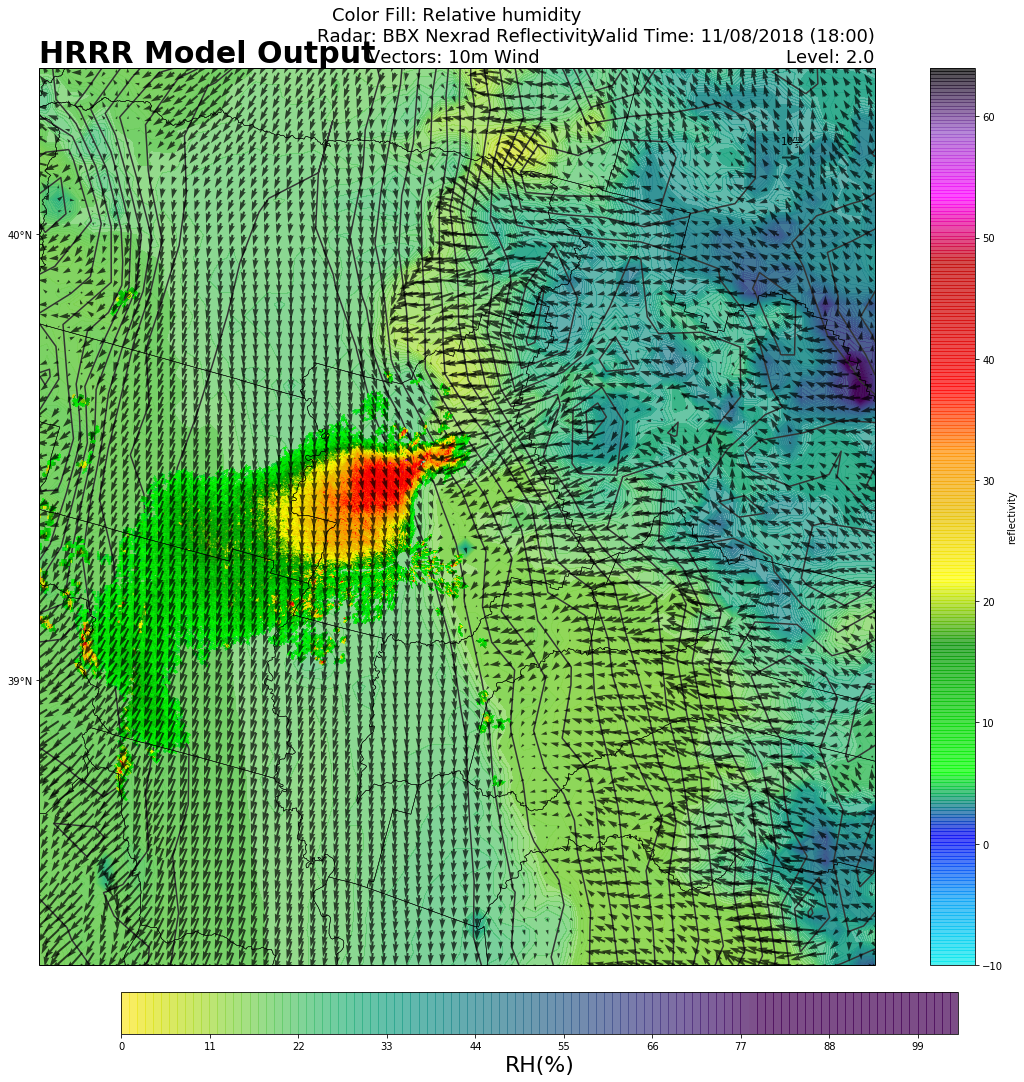

In [10]:
var = RH_2m

gf = pyart.filters.GateFilter(radar)
gf.exclude_transition()
gf.exclude_above('reflectivity', 100)
gf.exclude_below('reflectivity', 5)
despec = pyart.correct.despeckle_field(radar, 'reflectivity',gatefilter = gf, size = 20)
max_lat = 40.5
min_lat = 38.75
min_lon = -122.5
max_lon = -120.5

fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)

clevs = np.arange(0.,105.,1)
levs = np.arange(0,6000.,150)
levs2 = np.arange(1,3000.,250)
cf = ax.contourf(x,y,var, clevs, transform = ccrs.PlateCarree(), cmap = 'viridis_r', alpha = .7, zorder =1 , vmax = 80)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)
sknum = 1
skip=(slice(None,None,sknum),slice(None,None,sknum))
q = ax.quiver(x[skip].values,y[skip].values, uwind_10m[skip].values, vwind_10m[skip].values,  units='inches',  scale=40,\
              transform= ccrs.PlateCarree(), color = 'k',alpha = .7, zorder = 10)
ax.quiverkey(q, 0.9, 0.9, 10, r'$10 \frac{m}{s}$',coordinates ='axes' )
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.5, zorder = 1)

cb = fig.colorbar(cf, shrink=0.75, pad=.025, orientation = 'horizontal')

cb.set_label('RH(%)', size = 'x-large', fontsize = 22 )

display = pyart.graph.RadarMapDisplayCartopy(radar)    
display.plot_ppi_map('reflectivity', 0, 
             vmin=-10, vmax=64, colorbar_label='reflectivity', fig = fig, ax=ax,alpha = .7, gatefilter = gf)

plt.title('HRRR Model Output', loc='left', fontweight='bold', fontsize = 30)
plt.title('Color Fill: %s\nRadar: BBX Nexrad Reflectivity\nVectors: 10m Wind '%(var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time: %s\nLevel: %s' % (var.attrs['initial_time'], var.attrs['level']), loc='right', fontsize = 18)

In [ ]:
var = RH

fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)
clevs = np.arange(0.,105.,1)
levs = np.arange(0,6000.,500)
levs2 = np.arange(1,3000.,250)
cf = ax.contourf(x,y,var[26], clevs, transform = ccrs.PlateCarree(), cmap = 'viridis_r', alpha = .7, zorder = 2, vmax = 80)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)
#cs =ax.contour(lon_2d,lat_2d, heights_700,levs, transform = ccrs.PlateCarree(), linewidths = 3, colors = '#116000')
#ax.clabel(cs, cs.levels, fontsize=20, colors='k')

ax.scatter(-121.6219, 39.7596, s =300,  marker = '*', label = 'Paradise, California', transform = ccrs.PlateCarree(), color = 'tab:red', zorder =6)
sknum = 15
skip=(slice(None,None,sknum),slice(None,None,sknum))
ax.barbs(x[skip].values,y[skip].values, uwind_pres[26][skip].values, vwind_pres[26][skip].values, length=6,
             sizes=dict(emptybarb=0.25, spacing=.2, height=0.5),
             zorder = 5,
             linewidth=0.95, transform= ccrs.PlateCarree())
#ax.barbs(x[::50].values,y[::50].values, uwind_pres[26][::50].values, vwind_pres[26][::50].values, transform = ccrs.PlateCarree(), zorder = 5)
#ax.set_title('201]-11-08 0000UTC GFS 0.5°', fontsize = 30)
ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.2, zorder = 4)
ax.legend(loc = 1,fontsize = '18')
cb = fig.colorbar(cf, shrink=0.74, pad=0)
font_size = 20 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_label('RH (%)', size = 'x-large', fontsize = 22 )
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
    label.set_fontweight('bold');
plt.title('HRRR Model Output', loc='left', fontweight='bold', fontsize = 22)
plt.title('Field: %s' % (var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time: %s\nLevel: %s hPa' % (var.attrs['initial_time'], int(var[26].coords['lv_ISBL0'].data)/100), loc='right', fontsize = 18)
plt.savefig('HRRR_RH_%s_%sz_%s.png'% (var.attrs['initial_time'][3:5],var.attrs['initial_time'][12:14], int(var[26].coords['lv_ISBL0'].data)/100), dpi = 800, bbox_inches = 'tight')

In [ ]:
wp_lat =  39.697254
wp_lon = -121.574221

lat = data.gridlat_0
lon = data.gridlon_0
               
abslat = np.abs(lat-wp_lat)
abslon= np.abs(lon-wp_lon)
c = np.maximum(abslon,abslat)
xx, yy = np.where(c == np.min(c))
print(xx,yy) 